## Model infrastructure

We're going to predict the KPI data using the spatial data we've collected and aggregated into H3.

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import sklearn as sk
import matplotlib.pyplot as plt

## 1 Preparing the data

<Axes: >

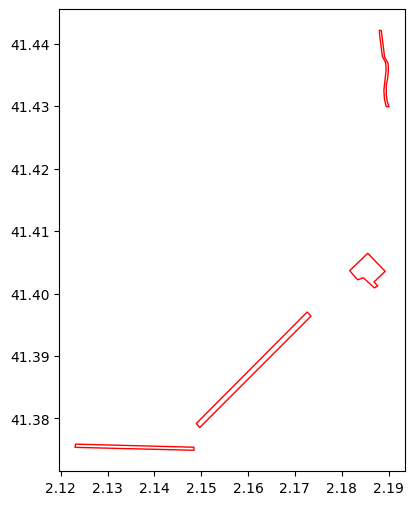

In [ ]:
#read in the BCN pilot 1 data from the geojson
# Read the GeoJSON file
gdf = gpd.read_file("data/Location/reallocate_all_pilots.geojson")

# Filter for Barcelona Pilot1
barcelona = gdf[(gdf["pilot"] == "Pilot1") & (gdf["city"] == "Barcelona")]

# Combine multiple polygons if necessary
barcelona_union = barcelona.dissolve(by="pilot")

In [36]:
#Read in the model-ready H3 data
h3 = gpd.read_parquet("data/processed/barcelona_h3_res10_aggregated_wide.parquet")

<Axes: >

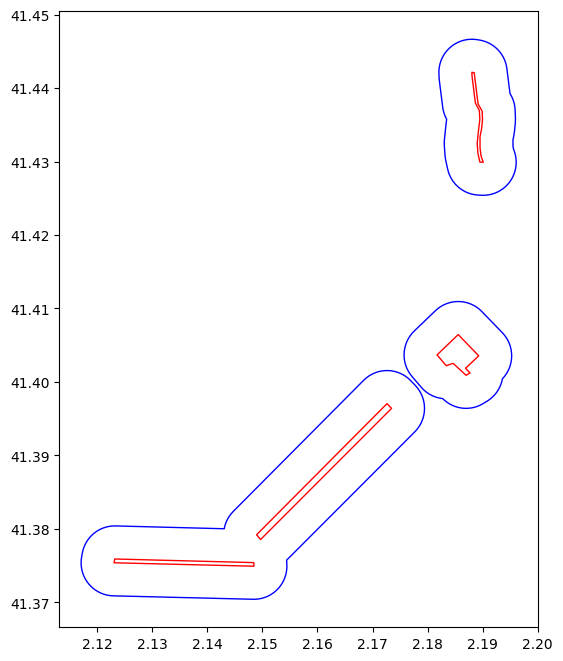

In [25]:
# Reproject to UTM zone that covers Barcelona, to work in meters
barcelona_utm = barcelona_union.to_crs(epsg=25831)  # ETRS89 / UTM zone 31N

# Buffer by 500 meters (change as appropriate)
barcelona_buffer = barcelona_utm.buffer(500)

# Convert back to WGS84
barcelona_buffer_wgs = gpd.GeoDataFrame(geometry=barcelona_buffer, crs="EPSG:25831").to_crs("EPSG:4326")


f, ax = plt.subplots(figsize=(8,8))
barcelona_buffer_wgs.plot(edgecolor="blue", facecolor="none", figsize=(6,6), ax=ax)
barcelona_union.plot(edgecolor="red", facecolor="none", ax=ax)


In [37]:
h3.crs

<Projected CRS: EPSG:25831>
Name: ETRS89 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 0°E and 6°E: Andorra; Denmark - offshore; Germany - offshore; Jan Mayen - offshore; Norway including Svalbard - onshore and offshore; Spain - mainland and Balearic islands - onshore and offshore.
- bounds: (0.0, 37.0, 6.01, 82.45)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

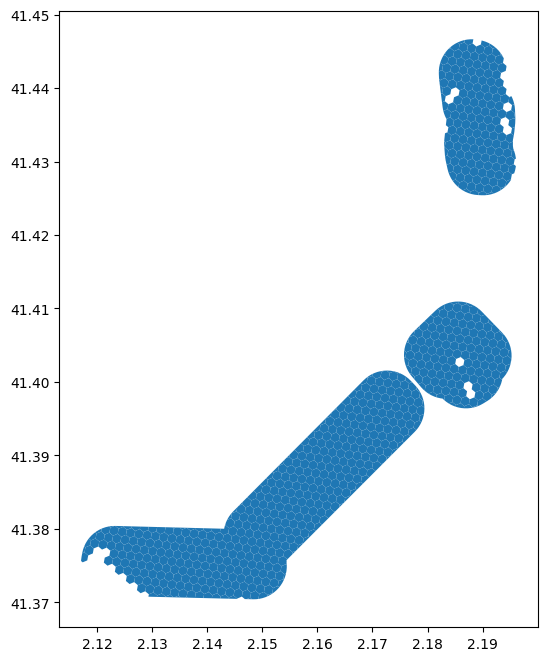

In [38]:
h3 = h3.to_crs("EPSG:4326")

# 6️⃣ Clip H3 polygons to the buffered area
h3_clipped = gpd.clip(h3, barcelona_buffer_wgs)

# 7️⃣ Optional: reproject back to EPSG:4326 
#h3_clipped = h3_clipped.to_crs("EPSG:4326")

#visualize
h3_clipped.plot(figsize=(8,8))

## Now the data is clipped, we can proceed with modelling steps...

## (M)GWR

In [40]:
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

In [ ]:
dataset = h3_clipped


In [ ]:
#Prepare Georgia dataset inputs
g_y = georgia_data['PctBach'].values.reshape((-1,1))
g_X = georgia_data[['PctFB', 'PctBlack', 'PctRural']].values
u = georgia_data['X']
v = georgia_data['Y']
g_coords = list(zip(u,v))

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0) #standardize independent variables

g_y = g_y.reshape((-1,1)) #convert to 2D array to use with MGWR

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0) #standardize dependent variable